Before we begin, we will change a few settings to make the notebook look a bit prettier

In [1]:
%%html
<style> body {font-family: "Calibri", cursive, sans-serif;} </style>


# 01 - DeepSurvK Quickstart
In this notebook, I will show DeepSurvK's basic functionality.

Before going forward, I recommend you check the previous notebook,
["Understanding DeepSurv"](./00_understanding_deepsurv.ipynb). 
There, you will learn the working principles of the original DeepSurv 
algorithm. Furthermore, there are also some useful usage recommendations 
that also apply here. However, I will just mention them without going
into the details.

## Preliminaries

Import packages

In [2]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

import deepsurvk
from deepsurvk.datasets import load_whas

## Get data
For convenience, DeepSurvK comes with DeepSurv's original datasets. 
This way, we can load sample data very easily (notice the import at the
top).

In [3]:
X_train, Y_train, E_train, = load_whas(partition='training', data_type='np')
X_test, Y_test, E_test = load_whas(partition='testing', data_type='np')

In [18]:
X_train

array([[-0.43816975, -0.4923276 , -0.86140656,  2.1718655 , -0.7221404 ,
        -0.70387053],
       [-0.43816975, -0.4923276 , -0.86140656,  2.1718655 , -0.7221404 ,
        -0.70387053],
       [-0.43816975, -0.4923276 , -0.86140656,  2.1718655 , -0.7221404 ,
        -0.70387053],
       ...,
       [ 2.2822206 , -0.12737222,  1.160892  , -1.6013273 , -0.7221404 ,
         1.4207158 ],
       [ 2.2822206 , -0.56531864,  1.160892  , -1.0156896 ,  1.3847724 ,
         1.4207158 ],
       [ 2.2822206 , -0.27335438,  1.160892  , -0.52968967,  1.3847724 ,
        -0.70387053]], dtype=float32)

These `training` and `testing` partitions correspond to the original
partitions used in DeepSurv's paper. 
However, you could also load the complete dataset using
`partition='complete'` and partition it as you wish (e.g., using
sklearn's [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html))

In [4]:
# Calculate important parameters.
n_patients_train = X_train.shape[0]
n_features = X_train.shape[1]

## Pre-process data
Data pre-processing is an important step. However, DeepSurvK leaves this
to the user, since it depends very much on the data themselves.
As mentioned in the [previous notebook]((./00_understanding_deepsurv.ipynb)), 
at the very least, I would recommend doing standardization and sorting:

In [5]:
# Standardization
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

Y_scaler = StandardScaler().fit(Y_train.reshape(-1, 1))
Y_train = Y_scaler.transform(Y_train)
Y_test = Y_scaler.transform(Y_test)

In [6]:
Y_train = Y_train.flatten()
Y_test = Y_test.flatten()

> Notice that if you read/have your data as a `pandas` DataFrame, you will
> get an error when reshaping `Y_train` (see [issue #81](https://github.com/arturomoncadatorres/deepsurvk/issues/81)). 
> That is because a DataFrame doesn't have the `reshape` attribute.
>
> In such case, you need to do the reshaping as follows:
>
> ```
> Y_scaler = StandardScaler().fit(Y_train.values.reshape(-1, 1))
> ```

In [7]:
# Sorting
sort_idx = np.argsort(Y_train)[::-1]
X_train = X_train[sort_idx]
Y_train = Y_train[sort_idx]
E_train = E_train[sort_idx]

> Notice that if you read/have your data as a `pandas` DataFrame, you will
> get an error when sorting (see [issue #82](https://github.com/arturomoncadatorres/deepsurvk/issues/82)). 
> That is because a DataFrame cannot be sorted like this.
>
> In such case, you need to do the sorting as follows:
>
> ```
> X_train = X_train.values[sort_idx]
> ...
> ```

## Create a DeepSurvK model
When creating an instance of a DeepSurvK model, we can also define its 
parameters. The only mandatory parameters are `n_features` and `E`.
If not defined, the rest of the parameters will use a default.
This is, of course, far from optimal, since (hyper)parameter tuning
has a *huge* impact on model performance. However, we will deal
with that later.

In [8]:
dsk = deepsurvk.DeepSurvK(n_features=n_features, E=E_train)

Since DeepSurvK is just a Keras model, we can take advantage of all the
perks and tools that come with it. For example, we can get an overview
of the model architecture very easily.

In [9]:
dsk.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (Dense)          (None, 6)                 42        
                                                                 
 DroputInput (Dropout)       (None, 6)                 0         
                                                                 
 HiddenLayer1 (Dense)        (None, 25)                175       
                                                                 
 Dropout1 (Dropout)          (None, 25)                0         
                                                                 
 HiddenLayer2 (Dense)        (None, 25)                650       
                                                                 
 Dropout2 (Dropout)          (None, 25)                0         
                                                                 
 OutputLayer (Dense)         (None, 1)                 2

## Callbacks
As mentioned earlier, it is practical to use Early Stopping in the
case of NaNs in loss values. Additionally, it is also a good idea
to use the model that during the training phase yields the lowest loss
(which isn't necessarily the one at the end of the training)

Both of these practices can be achieved using [callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback).
DeepSurvK provides a method to generate these two specific callbacks.

In [10]:
callbacks = deepsurvk.common_callbacks()
print(callbacks)

[<keras.callbacks.TerminateOnNaN object at 0x00000189A62EB910>, <keras.callbacks.ModelCheckpoint object at 0x00000189A62EB970>]


Needless to say that you can define your own callbacks as well, of course.

## Model fitting
After this, we are ready to actually fit our model (as any Keras model).

In [ ]:
epochs = 1000
history = dsk.fit(X_train, Y_train, 
                  batch_size=n_patients_train,
                  epochs=epochs, 
                  callbacks=callbacks,
                  shuffle=False)

> In some cases, it has been reported that while fitting a model,
> the [loss goes to a `NaN` very early](https://github.com/arturomoncadatorres/deepsurvk/issues/83),
> making the training process unfeasible, even with the previously defined
> callback. I haven't been able to replicate that issue consistently.
> 
> However, this issue has also [been reported in the original DeepSurv](https://github.com/jaredleekatzman/DeepSurv/issues/14).
> Apparently, a potentially good solution for this is to *not* 
> standardize your data during the pre-procesing, but rather
> normalizing it (i.e., make sure that features are in the range 0-1).
> However, remember that scaling is particularly sensitive to
> outliers, so be careful!

DeepSurvK provides a few wrappers to generate visualizations that are
often required fast and easy.

(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:xlabel='No. epochs', ylabel='Loss [u.a.]'>)

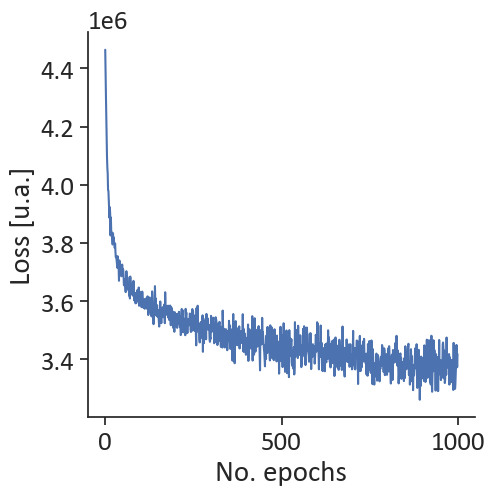

In [12]:
deepsurvk.plot_loss(history)

## Model predictions
Finally, we can generate predictions using our model.
We can evaluate them using the c-index.

In [13]:
Y_pred_train = np.exp(-dsk.predict(X_train))
c_index_train = deepsurvk.concordance_index(Y_train, Y_pred_train, E_train)
print(f"c-index of training dataset = {c_index_train}")

Y_pred_test = np.exp(-dsk.predict(X_test))
c_index_test = deepsurvk.concordance_index(Y_test, Y_pred_test, E_test)
print(f"c-index of testing dataset = {c_index_test}")

c-index of training dataset = 0.8774733283547672
c-index of testing dataset = 0.8333614210118305
